<div style=" padding: 20px"> <h1 style=" margin-bottom:20px">Описание проекта</h1>
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.
Вы изучите:
как люди пользуются продуктом,
когда они начинают покупать,
сколько денег приносит каждый клиент
когда клиент окупается.

### Шаг 1. Загружаю данные и подготавливаю их к анализу
Загружаю данные о визитах, заказах и расходах в переменные. Оптимизирую данные для анализа. 

In [1]:
import pandas as pd
visits = pd.read_csv('/datasets/visits_log.csv')
print(visits.head())
print(visits.info())

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [2]:
orders_log = pd.read_csv('/datasets/orders_log.csv')
print(orders_log.head())
print(orders_log.info())

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [3]:
costs = pd.read_csv('/datasets/costs.csv')
costs['dt'] = costs['dt'].astype('datetime64[M]')
print(costs.head())
#print(costs.info())
#costs.groupby('dt').agg({'costs':'sum'})

   source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-01  62.25
2          1 2017-06-01  36.53
3          1 2017-06-01  55.00
4          1 2017-06-01  57.08


Тип данных в датах не правильный привожу к datetime64. Проверяю на пропуски и дубликаты.

In [4]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])
print(visits.info())
print(orders_log.info())
print(costs.info())
print(visits.duplicated().sum())
print(visits.isnull().sum())
print(orders_log.duplicated().sum())
print(orders_log.isnull().sum())
print(costs.duplicated().sum())
print(costs.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None
0
Device       0
End Ts    

Проверяю максимальное значение выручки Яндекс.Афиши с этого заказа

In [5]:
print(orders_log.ix[orders_log['Revenue'].idxmax()])

Buy Ts     2017-12-10 20:17:00
Revenue                2633.28
Uid        5539673724080479777
Name: 23244, dtype: object


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.
Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:
 sticky factor = DAU/WAU или sticky factor = DAU/MAU - регулярность использования — то, как часто пользователи к нему обращаются.

In [6]:
visits['session_year']  = visits['Start Ts'].astype('datetime64[Y]')
visits['session_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['session_week']  = visits['Start Ts'].astype('datetime64[W]')
visits['session_date'] = visits['Start Ts'].astype('datetime64[D]')

mau_total = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
dau_total = visits.groupby(['session_year', 'session_date']).agg({'Uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()


sticky_wau = dau_total/wau_total*100
sticky_mau = dau_total/mau_total*100

print('sticky_wau',sticky_wau)
print('sticky_mau', sticky_mau)
visits.rename(columns = {'Source Id':'Source_Id'}, inplace = True)

sticky_wau Uid    16.151541
dtype: float64
sticky_mau Uid    3.90897
dtype: float64


In [7]:
values = visits['Source_Id'].value_counts().index.tolist()
print(values)

[4, 3, 5, 2, 1, 9, 10, 7, 6]


In [8]:
# 1
print(visits.head(2))

    Device              End Ts  Source_Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   

                    Uid session_year session_month session_week session_date  
0  16879256277535980062   2017-01-01    2017-12-01   2017-12-14   2017-12-20  
1    104060357244891740   2018-01-01    2018-02-01   2018-02-15   2018-02-19  


In [9]:
# 1
visits.head(2)

,Device,End Ts,Source_Id,Start Ts,Uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19


Вычислим для каждого пользователя время и источник его первого визита

In [10]:
first_Source_Id = visits.sort_values(by=['Start Ts']).groupby('Uid').first()
first_Source_Id['first_Source_Id']=first_Source_Id['Source_Id']
first_Source_Id['first_Start_Ts']=first_Source_Id['Start Ts']
first_Source_Id['first_Device']=first_Source_Id['Device']
first_Source_Id = first_Source_Id.reset_index()
visits = visits.merge(first_Source_Id[['Uid','first_Source_Id','first_Start_Ts','first_Device']], on='Uid')

print(visits.head())


    Device              End Ts  Source_Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   

                    Uid session_year session_month session_week session_date  \
0  16879256277535980062   2017-01-01    2017-12-01   2017-12-14   2017-12-20   
1    104060357244891740   2018-01-01    2018-02-01   2018-02-15   2018-02-19   
2   7459035603376831527   2017-01-01    2017-07-01   2017-06-29   2017-07-01   
3  16174680259334210214   2018-01-01    2018-05-01   2018-05-17   2018-05-20   
4  16174680259334210214   2018-01-01    2018-03-01   2018-03-08   2018-03-09   

   first_Source_Id      first_Start_Ts first_Device  
0                4 2017-12-20 17:20:00        touch  
1                2 2

### Посчитаем сколько длится одна сессия:

In [11]:
import numpy as np
visits['sessia']=visits['End Ts']-visits['Start Ts']
#visits['sessia']=visits['sessia'].total_seconds()/60
visits['sessia'] = visits['sessia'].apply(lambda x : x.total_seconds() / 60.0)
#print(visits.head())
import matplotlib.pyplot as plt
#sessia =  pd.pivot_table(visits, index='session_date', columns=['Device'], values='sessia', aggfunc= {'sessia': 'mean'}  )
#sessia.plot( grid=True, figsize=(20, 5),title='Длительность сессии в минутах, график по дням')
#plt.show()



### <span style="color:blue">Cколько длится одна сессия:<span>

In [12]:
sessia =  visits.groupby(['session_date', 'first_Source_Id']).agg({'sessia':'mean'}).reset_index()
print('Cколько длится одна сессия на различных источниках: {} '.format(sessia.groupby('first_Source_Id').agg({'sessia': 'mean'}).sort_values(by='sessia', ascending=False)))

Cколько длится одна сессия на различных источниках:                     sessia
first_Source_Id           
1                15.647906
2                14.107266
10               10.831461
7                10.323529
3                 9.822872
9                 9.699882
4                 9.245458
5                 8.820209
6                 6.833333 


In [13]:
sessia =  visits.groupby(['session_date', 'Device']).agg({'sessia':'mean'}).reset_index()
print('Cколько длится одна сессия по различным устройствам: {} '.format(sessia.groupby('Device').agg({'sessia': 'mean'})))

Cколько длится одна сессия по различным устройствам:             sessia
Device            
desktop  11.351237
touch     7.727787 


### Посчитаем сколько сессий в день:

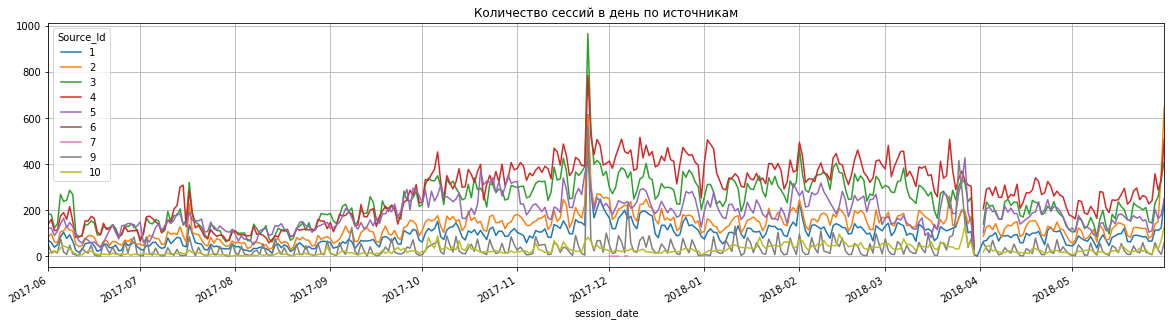

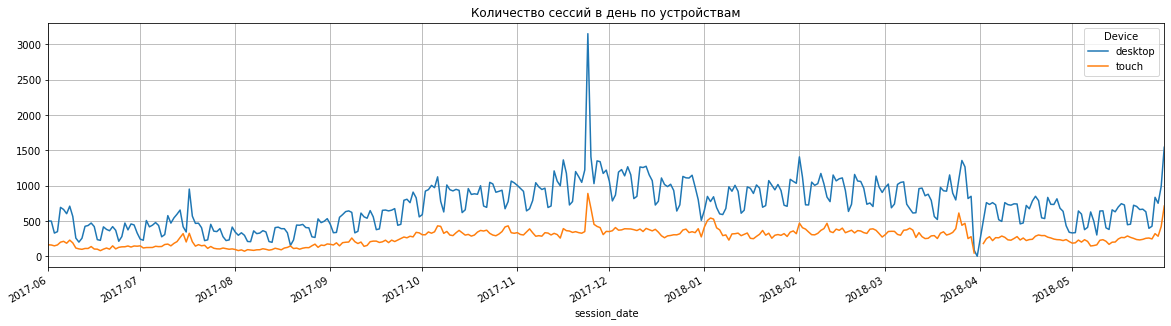

In [17]:
import matplotlib.pyplot as plt
count_session_first_Source_Id =  pd.pivot_table(visits, index='session_date', columns=['Source_Id'], values='sessia', aggfunc=lambda x: len(x)  )
count_session_first_Source_Id.plot( grid=True, figsize=(20, 5),title='Количество сессий в день по источникам')
plt.show()
count_session_Device =  pd.pivot_table(visits, index='session_date', columns=['Device'], values='sessia', aggfunc=lambda x: len(x)  )
count_session_Device.plot( grid=True, figsize=(20, 5),title='Количество сессий в день по устройствам')
plt.show()

### <span style="color:blue">Количество сессий в день:<span>

In [18]:
count_session_Device =  visits.groupby(['session_date', 'Device']).agg({'sessia': lambda x: len(x)}).reset_index()
print('Количество сессий в день по различным устройствам: {} '.format(count_session_Device.groupby('Device').agg({'sessia': 'mean'})))

Количество сессий в день по различным устройствам:              sessia
Device             
desktop  721.337912
touch    266.757576 


In [19]:
count_session_Device =  visits.groupby(['session_date', 'Source_Id']).agg({'sessia': lambda x: len(x)}).reset_index()
print('Количество сессий в день по различным источникам: {} '.format(count_session_Device.groupby('Source_Id').agg({'sessia': 'mean'}).sort_values(by='sessia', ascending=False)))

Количество сессий в день по различным источникам:                sessia
Source_Id            
4          280.424242
3          235.840220
5          184.311295
2          131.201102
1           93.739011
9           36.575758
10          27.617080
7            1.058824
6            1.000000 



### Сколько людей пользуются в день, неделю, месяц?

In [20]:
import matplotlib.pyplot as plt
#mau_source =  pd.pivot_table(visits, index='session_month', columns=['Source_Id'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#mau_source.plot( grid=True, figsize=(20, 5),title='MAU по источникам')
#plt.show()
#mau_device =  pd.pivot_table(visits, index='session_month', columns=['Device'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#mau_device.plot( grid=True, figsize=(20, 5),title='MAU по устройствам')
#plt.show()

mau_month_source = visits.groupby(['session_month', 'Source_Id']).agg({'Uid':'nunique'}).reset_index()
mau_device = visits.groupby(['session_month', 'Device']).agg({'Uid':'nunique'}).reset_index()

### <span style="color:blue">Cколько людей пользуются в месяц:<span>

In [21]:
# средний MAU по source id
print('Cколько людей пользуется в месяц (MAU) по источникам:',mau_month_source.groupby('Source_Id').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))
print('Cколько людей пользуется в месяц (MAU) по устройствам:',mau_device.groupby('Device').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))

Cколько людей пользуется в месяц (MAU) по источникам:                    Uid
Source_Id             
4          7765.666667
3          6758.833333
5          5017.916667
2          2752.083333
1          1818.750000
9           987.000000
10          707.000000
7             2.833333
6             1.000000
Cколько людей пользуется в месяц (MAU) по устройствам:                   Uid
Device               
desktop  16724.916667
touch     6825.916667


график MAU построен по данным за год. Граффик Mau с июля до конца года растет. Но нельзя исключить сезонность так как данные только за год.

In [22]:
#wau_source =  pd.pivot_table(visits, index='session_week', columns=['first_Source_Id'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#wau_source.plot( grid=True, figsize=(20, 5),title='WAU по источникам')
#plt.show()
#wau_device =  pd.pivot_table(visits, index='session_week', columns=['Device'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#wau_device.plot( grid=True, figsize=(20, 5),title='WAU по устройствам')
#plt.show()
wau_month_source = visits.groupby(['session_week', 'Source_Id']).agg({'Uid':'nunique'}).reset_index()
wau_device =  visits.groupby(['session_week', 'Device']).agg({'Uid':'nunique'}).reset_index()


### <span style="color:blue">Cколько людей пользуются в неделю:<span>

In [23]:
print('Cколько людей пользуется в неделю (WAU) по источникам:',wau_month_source.groupby('Source_Id').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))
print('Cколько людей пользуется в неделю (WAU) по устройствам:',wau_device.groupby('Device').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))

Cколько людей пользуется в неделю (WAU) по источникам:                    Uid
Source_Id             
4          1830.622642
3          1565.509434
5          1168.018868
2           716.358491
1           464.698113
9           238.339623
10          166.509434
7             1.440000
6             1.000000
Cколько людей пользуется в неделю (WAU) по устройствам:                  Uid
Device              
desktop  4135.754717
touch    1637.264151


WAU растет. Виден рост с июля по конец когда. Вероятно связанно с сезонностью. Но если сравнивать конец года то виден тоже рост. Например по устройствам там где было 3000 пользователей к концу года стало около 4000.

In [24]:
#dau_source =  pd.pivot_table(visits, index='session_date', columns=['Source_Id'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#dau_source.plot( grid=True, figsize=(20, 5),title='DAU')
#plt.show()
#dau_device =  pd.pivot_table(visits, index='session_date', columns=['Device'], values='Uid', aggfunc= {'Uid': 'nunique'}  )
#dau_device.plot( grid=True, figsize=(20, 5),title='DAU')
#plt.show()
dau_month_source = visits.groupby(['session_date', 'Source_Id']).agg({'Uid':'nunique'}).reset_index()
dau_device= visits.groupby(['session_date', 'Device']).agg({'Uid':'nunique'}).reset_index()

DAU вероятно меньше пользуются в выходные. И по хорошему надо более детально посмотреть на распределения цену конверсии на выходные.

### <span style="color:blue">Cколько людей пользуются в день:<span>

In [25]:
print('Cколько людей пользуется в день (DAU) по источникам:',dau_month_source.groupby('Source_Id').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))
print('Cколько людей пользуется в день (DAU) по устройствам:',dau_device.groupby('Device').agg({'Uid': 'mean'}).sort_values(by='Uid', ascending=False))

Cколько людей пользуется в день (DAU) по источникам:                   Uid
Source_Id            
4          275.454545
3          232.865014
5          175.622590
2          120.707989
1           80.557692
9           36.110193
10          26.033058
7            1.058824
6            1.000000
Cколько людей пользуется в день (DAU) по устройствам:                 Uid
Device             
desktop  659.244505
touch    252.873278


Посмотрим до какого месяца у нас есть данные. Так как в июне у нас только один переход удалим его.

In [27]:
print(orders_log.sort_values(by=['Buy Ts'], ascending=False).head(10))
orders_log.drop(orders_log.loc[orders_log['Uid']==83872787173869366].index, inplace=True)

                   Buy Ts  Revenue                   Uid
50414 2018-06-01 00:02:00     3.42     83872787173869366
50413 2018-05-31 23:56:00     3.67   3993697860786194247
50412 2018-05-31 23:54:00     0.30   1786462140797698849
50411 2018-05-31 23:50:00     5.80  11369640365507475976
50410 2018-05-31 23:50:00     4.64  12296626599487328624
50409 2018-05-31 23:43:00     3.67   1805512004303848280
50408 2018-05-31 23:42:00     0.92  15854392578508828030
50407 2018-05-31 23:40:00     2.26  15576344609395725707
50406 2018-05-31 23:40:00     1.16  13121453305610619664
50405 2018-05-31 23:36:00     0.61   1551265230644458155


Проведем атрибуцию. Привяжем оплату к визиту. Для этого к каждой покупке найдем ближайшую к ней сессию в прошлое. А затем для каждой такой сессии найдем сумму покупок и минимальное время. Потому что одна сессия может приводить к нескольким покупкам, но для нашей аналитики это не так важно.

In [28]:
#print(visits.info())
#print(orders_log.info())
#print('_______________________________________________')
#print(orders_log['Revenue'].sum())
visits_start=visits[['Start Ts', 'Uid']].sort_values( 'Start Ts')
orders_log=orders_log.sort_values('Buy Ts')
orders_log_visits = pd.merge_asof(orders_log, visits_start , by='Uid', direction='backward', left_on ='Buy Ts', right_on='Start Ts')
orders_log_visits = orders_log_visits.groupby(['Start Ts','Uid']).agg({'Revenue': 'sum','Buy Ts': 'min'}).reset_index()

new_data=visits.merge(orders_log_visits, on = ['Start Ts','Uid'], how = 'outer')
#print(new_data.head(10))
#print(new_data.info())
#print('_______________________________________________')
#print(new_data['Revenue'].sum())


Сгруппируем данные по столбцу 'Uid' методом groupby(). Для каждого клиента получим дату его первого заказа — 

In [29]:
first_buy_ts_customers = new_data.groupby('Uid')['Buy Ts'].min()
print (first_buy_ts_customers.head())

Uid
11863502262781                    NaT
49537067089222                    NaT
297729379853735                   NaT
313578113262317   2018-01-03 21:51:00
325320750514679                   NaT
Name: Buy Ts, dtype: datetime64[ns]


В исходной таблице orders уже есть столбец Buy Ts. Чтобы в результирующем датафрейме не было двух столбцов с одинаковыми названиями, изменим имя Series на first_buy_date, обратившись к атрибуту name у Series. Причём менять нужно имя Series, а не название переменной, где она сохранена:
Методом join() объединим датафрейм orders и Series first_buy_ts_customers по столбцу 'Uid':

In [30]:
first_buy_ts_customers.name = 'first_buy_date'

In [31]:
new_data = new_data.join(first_buy_ts_customers,on='Uid')
#print(new_data.head(50))

### <span style="color:blue">Когда люди начинают покупать (время от первого захода до покупки)<span>

Выбросим из аналитики пользователей которые совершили покупку более чем через 30 дней от первого захода, считаем их повторно привличенными пользователи. Возьмем median так как более устойчива к выбросам.

In [32]:
import sys

new_data['before_buy_ts'] = new_data['first_buy_date']-new_data['first_Start_Ts']
new_data['before_buy_ts'] = new_data['before_buy_ts']/ np.timedelta64(1, 's') / 60.0
new_data['first_buy_date_d']=new_data['first_Start_Ts'].astype('datetime64[W]') 

#buy_first_data = new_data
buy_first_data = new_data[new_data['before_buy_ts'] < 30*24*60]

#print(buy_first_data.head())
#new_data_date = new_data.groupby(['Uid','Device','first_buy_date','before_buy_ts']).reset_index()
buy_first_data = buy_first_data[['Uid','first_Device','first_Source_Id','first_buy_date_d','before_buy_ts']].drop_duplicates().dropna()

#before_buy_ts =  pd.pivot_table(buy_first_data, index='first_buy_date_d', columns=['first_Device'], values='before_buy_ts', aggfunc= {'before_buy_ts': 'median'}  )
#before_buy_ts.plot( grid=True, figsize=(20, 5),title='Когда люди начинают покупать')
#plt.show()


In [33]:
buy_first_data.groupby('first_Device')['before_buy_ts'].describe()

,count,mean,std,min,25%,50%,75%,max
first_Device,,,,,,,,
desktop,25465.0,2026.176949,6442.806235,0.0,3.0,10.0,77.0,43190.0
touch,6093.0,2938.466437,7579.626216,0.0,3.0,15.0,1043.0,43093.0


In [34]:
buy_first_data.groupby('first_Source_Id')['before_buy_ts'].describe()

,count,mean,std,min,25%,50%,75%,max
first_Source_Id,,,,,,,,
1,2661.0,1800.646749,5822.702106,0.0,2.0,7.0,69.00,43096.0
2,2920.0,2434.644521,6942.746287,0.0,3.0,11.0,321.50,42982.0
3,8995.0,2290.802001,6834.661078,0.0,3.0,12.0,151.00,43025.0
4,8921.0,2311.883197,6907.683582,0.0,3.0,12.0,152.00,43190.0
5,6149.0,1760.863067,5974.296211,0.0,2.0,8.0,50.00,43113.0
7,1.0,52.000000,NaN,52.0,52.0,52.0,52.00,52.0
9,707.0,4820.540311,9837.186552,0.0,6.0,29.0,3423.00,43071.0
10,1204.0,1772.586379,5740.916714,0.0,3.0,9.0,71.25,43118.0


In [35]:
device_buy_first = buy_first_data.groupby(['first_buy_date_d', 'first_Device']).agg({'before_buy_ts':'median'}).reset_index()
print('В среднем пользователь который совершает покупку делает через  часов (по устройствам):',device_buy_first.groupby('first_Device').agg({'before_buy_ts': 'mean'}))

В среднем пользователь который совершает покупку делает через  часов (по устройствам):               before_buy_ts
first_Device               
desktop            9.896226
touch             14.764151


## <span style="color:red">Попробуем повторить выкладки<span>

In [36]:
# вычисляем дату первого визита, первый девайс и первый источник для пользователя
# объединяем по пользователю с таблицей заказов и рассчитываем время до первой покупки в секундах
df1 = orders_log.merge(
        visits\
            .sort_values(by='Start Ts')\
            .groupby('Uid')\
            .agg({'Start Ts':'min','Source_Id': 'first', 'Device': 'first'})\
            .reset_index()\
            .rename(columns={'Start Ts': 'first_visit_date', 'Source_Id': 'first_source', 'Device': 'first_device'}),
    on='Uid', how='inner')\
    .assign(time_to_buy = lambda row: (row['Buy Ts'] - row['first_visit_date']).dt.total_seconds())

df1 = df1.groupby(['Uid','first_source','first_device']).agg({'time_to_buy':'min'}).reset_index()
df1.sort_values(by=['Uid']).head()

,Uid,first_source,first_device,time_to_buy
0,313578113262317,2,desktop,9241320.0
1,1575281904278712,10,touch,0.0
2,2429014661409475,3,desktop,4740.0
3,2464366381792757,5,desktop,71040.0
4,2551852515556206,5,desktop,0.0


In [37]:
# время до первой покупки в минутах по источникам
df1[df1['time_to_buy']/3600 < 720].groupby('first_source')['time_to_buy'].describe()/60

,count,mean,std,min,25%,50%,75%,max
first_source,,,,,,,,
1,44.350000,1800.646749,5822.702106,0.0,2.0,7.0,69.00,43096.0
2,48.666667,2434.644521,6942.746287,0.0,3.0,11.0,321.50,42982.0
3,149.916667,2290.802001,6834.661078,0.0,3.0,12.0,151.00,43025.0
4,148.683333,2311.883197,6907.683582,0.0,3.0,12.0,152.00,43190.0
5,102.483333,1760.863067,5974.296211,0.0,2.0,8.0,50.00,43113.0
7,0.016667,52.000000,NaN,52.0,52.0,52.0,52.00,52.0
9,11.783333,4820.540311,9837.186552,0.0,6.0,29.0,3423.00,43071.0
10,20.066667,1772.586379,5740.916714,0.0,3.0,9.0,71.25,43118.0


In [38]:
# время до первой покупки по девайсам в часах
df1.groupby('first_device')['time_to_buy'].describe()//60

,count,mean,std,min,25%,50%,75%,max
first_device,,,,,,,,
desktop,486.0,23056.0,66477.0,0.0,4.0,15.0,1629.0,523144.0
touch,121.0,29472.0,72555.0,0.0,4.0,38.0,10031.0,522287.0


In [39]:
# время до первой покупки по девайсам в минутах с фильтром менее 720 минут
df1[df1['time_to_buy']/3600 < 720].groupby('first_device')['time_to_buy'].describe()/60

,count,mean,std,min,25%,50%,75%,max
first_device,,,,,,,,
desktop,424.416667,2026.176949,6442.806235,0.0,3.0,10.0,77.0,43190.0
touch,101.550000,2938.466437,7579.626216,0.0,3.0,15.0,1043.0,43093.0


В таблице появился столбец first_buy_date_month с датами первой покупки клиента.
Следующим шагом выделим из столбцов first_buy_date_month и Buy Ts месяцы. Вызовем метод astype(): преобразуем значения столбцов к типу 'datetime64  

In [40]:
new_data['first_buy_date_month'] = new_data['first_buy_date'].astype('datetime64[M]')
new_data['Buy Ts_month'] = new_data['Buy Ts'].astype('datetime64[M]')
print(new_data.head(10))

    Device              End Ts  Source_Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
5  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
6  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
7  desktop 2017-10-27 16:02:00          3 2017-10-27 15:20:00   
8  desktop 2017-09-04 17:56:00          4 2017-09-04 17:37:00   
9  desktop 2017-10-28 00:04:00          3 2017-10-27 23:56:00   

                    Uid session_year session_month session_week session_date  \
0  16879256277535980062   2017-01-01    2017-12-01   2017-12-14   2017-12-20   
1    104060357244891740   2018-01-01    2018-02-01   2018-02-15   2018-02-19   
2   7459035603376831527   2017-01-01    2017

### <span style="color:blue">Сколько раз покупают в месяц:<span>

In [41]:
buy_grouped = new_data.groupby(['first_buy_date_month','Buy Ts_month','Device', 'Source_Id']).agg({'Uid':'nunique','Revenue': lambda x: len(x)}).dropna()
buy_grouped['buy_per_user'] = buy_grouped['Revenue'] / buy_grouped['Uid']
buy_per_user = buy_grouped.pivot_table(index='first_buy_date_month',columns='Buy Ts_month',values='buy_per_user',aggfunc='mean')
buy_per_user.fillna('')

Buy Ts_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_date_month,,,,,,,,,,,,
2017-06-01,1.04672,1.3729,1.40125,1.81131,1.44387,1.69317,1.74228,2.01293,1.5753,1.57143,1.25893,1.264610
2017-07-01,,1.04388,1.26786,1.43994,1.34319,1.10043,1.35606,1.13148,1,1.05291,1.0625,1.340608
2017-08-01,,,1.03591,1.3412,1.2197,1.42778,1.29563,1.80625,1.48182,1.24167,1.27604,1.174242
2017-09-01,,,,1.02972,1.28074,1.16197,1.21935,1.09877,1.15162,1.12121,1.12917,1.103175
2017-10-01,,,,,1.03948,1.12515,1.06503,1.06825,1.05846,1.14152,1.08268,1.449883
2017-11-01,,,,,,1.07273,1.33141,1.20157,1.31949,1.18016,1.10101,1.297078
2017-12-01,,,,,,,1.0554,1.23789,1.32825,1.19529,1.15385,1.169814
2018-01-01,,,,,,,,1.05314,1.37233,1.19602,1.07639,1.291667
2018-02-01,,,,,,,,,1.05407,1.40979,1.14343,1.245833


### <span style="color:blue">Какой средний чек:<span>

Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на Uid:
Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени:

In [42]:
cohort_grouped = new_data.groupby(['first_buy_date_month','Buy Ts_month','Device', 'Source_Id']).agg({'Uid':'nunique','Revenue':'sum'})

cohort_grouped_month = new_data.groupby(['first_buy_date_month','Buy Ts_month']).agg({'Uid':'nunique','Revenue':'sum'})

cohort_grouped_month['revenue_per_user'] = cohort_grouped_month['Revenue'] / cohort_grouped_month['Uid']
revenue_per_user = cohort_grouped_month.pivot_table(index='first_buy_date_month',columns='Buy Ts_month',values='revenue_per_user',aggfunc='mean')
revenue_per_user.fillna('')

Buy Ts_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_date_month,,,,,,,,,,,,
2017-06-01,4.89676,18.1364,21.2956,41.1257,29.7913,25.9588,34.8804,28.3961,21.1755,30.6315,30.61,10.129783
2017-07-01,,6.18445,15.9153,27.3677,12.1094,7.26156,8.23324,7.16172,7.20935,8.08611,13.4162,12.228750
2017-08-01,,,5.50248,15.0095,12.8893,15.1344,19.9561,12.5691,10.82,14.3989,21.1206,8.484138
2017-09-01,,,,5.80497,27.1401,13.9158,164.111,36.2152,23.8398,35.0009,14.7923,12.147500
2017-10-01,,,,,5.17989,12.8355,6.9986,8.60675,7.73549,8.14567,7.17348,8.213704
2017-11-01,,,,,,5.25448,8.22276,7.92228,14.4762,8.68108,4.75622,8.599804
2017-12-01,,,,,,,4.82783,9.25225,60.7899,72.6138,8.77667,7.439184
2018-01-01,,,,,,,,4.19721,10.6246,15.2195,11.7926,4.868462
2018-02-01,,,,,,,,,4.22572,10.3242,6.1815,5.554000


Построим сводную таблицу изменения количества покупателей в когортах по месяцу совершения покупки и оценим, как изменяется количество с течением времени:

In [46]:
import seaborn as sns

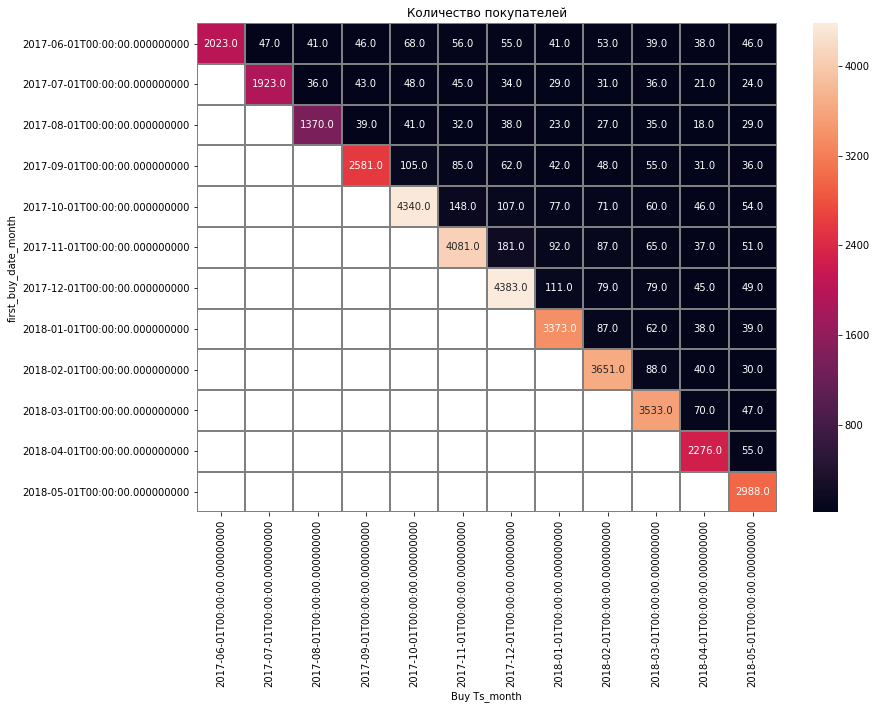

In [47]:
revenue_per_Uid_nunique = cohort_grouped_month.pivot_table(index='first_buy_date_month',columns='Buy Ts_month',values='Uid')
plt.figure(figsize=(13, 9))
plt.title('Количество покупателей')
sns.heatmap(revenue_per_Uid_nunique, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Найдём lifetime когорты. Из месяца совершения заказа Buy Ts_month вычтем месяц когорты first_buy_date_month:
Получили столбец cohort_lifetime с типом timedelta. Он хранит в себе разницу между двумя датами. 
Преобразуем этот тип в число месяцев, прошедших между датами. Для этого cohort_lifetime нужно разделить на константу np.timedelta64(1, 'M') — узнать, сколько величин длиной в 1 месяц содержится в cohort_lifetime. Константа np.timedelta64(1, 'M') есть только в Numpy, импортируем библиотеку:
Получили дробные числа. Это связано с тем, что константа np.timedelta64(1,'M') представляет собой среднюю длину месяца в году. В месяце бывает от 28 дней до 31, вот и числа вышли не целые. Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к целочисленному типу методом astype('int'):


In [48]:
import numpy as np
cohort_grouped_month = cohort_grouped_month.reset_index()
cohort_grouped_month['cohort_lifetime'] = cohort_grouped_month['Buy Ts_month'] - cohort_grouped_month['first_buy_date_month']
cohort_grouped_month['cohort_lifetime'] = cohort_grouped_month['cohort_lifetime'] /np.timedelta64(1,'M') 
cohort_grouped_month['cohort_lifetime'] = cohort_grouped_month['cohort_lifetime'].round().astype('int')
#print(cohort_grouped.head())
#print('----------------------------')
#lifetime_pivot = cohort_grouped_month.pivot_table(index='first_buy_date_month',columns='cohort_lifetime',values='revenue_per_user')
#lifetime_pivot.fillna('')

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю. Переименуем столбец user_id в cohort_users методом rename(). Параметру columns передадим словарь, где ключ — старое название столбца, а значение — новое.Объединим данные по когортам с исходным количеством пользователей в когорте.Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте. Построим сводную таблицу и создадим тепловую карту:


### <span style="color:blue">Как часто люди возвращаются:<span>

In [49]:
cohort_grouped_month = cohort_grouped_month.reset_index()
cohort_grouped_time = cohort_grouped_month.groupby(['first_buy_date_month','cohort_lifetime']) .agg({'Uid':'sum'}).reset_index()

initial_users_count = cohort_grouped_time[cohort_grouped_time['cohort_lifetime'] == 0][['first_buy_date_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

cohort_grouped_time = cohort_grouped_time.merge(initial_users_count,on='first_buy_date_month', validate='many_to_one')

cohort_grouped_time['Retention'] = cohort_grouped_time['Uid']/cohort_grouped_time['cohort_users']*100
print('Процент пользователей возвращающихся на следующий месяц')
retention_pivot = cohort_grouped_time.pivot_table(index='first_buy_date_month',columns='cohort_lifetime',values='Retention')
retention_pivot.round(2).fillna('')


Процент пользователей возвращающихся на следующий месяц


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_date_month,,,,,,,,,,,,
2017-06-01,100.0,2.32,2.03,2.27,3.36,2.77,2.72,2.03,2.62,1.93,1.88,2.27
2017-07-01,100.0,1.87,2.24,2.5,2.34,1.77,1.51,1.61,1.87,1.09,1.25,
2017-08-01,100.0,2.85,2.99,2.34,2.77,1.68,1.97,2.55,1.31,2.12,,
2017-09-01,100.0,4.07,3.29,2.4,1.63,1.86,2.13,1.2,1.39,,,
2017-10-01,100.0,3.41,2.47,1.77,1.64,1.38,1.06,1.24,,,,
2017-11-01,100.0,4.44,2.25,2.13,1.59,0.91,1.25,,,,,
2017-12-01,100.0,2.53,1.8,1.8,1.03,1.12,,,,,,
2018-01-01,100.0,2.58,1.84,1.13,1.16,,,,,,,
2018-02-01,100.0,2.41,1.1,0.82,,,,,,,,


In [50]:
#sns.set(style='white')
#plt.figure(figsize=(13, 9))
#plt.title('Cohorts: Как часто люди возвращаются Retention Rate')
#sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Построим сводную таблицу по устройствам пользователя:

In [51]:
cohort_grouped_device = new_data.groupby(['first_buy_date_month','Buy Ts_month','Device']).agg({'Uid':'nunique','Revenue':'sum'})
cohort_grouped_device = cohort_grouped_device.reset_index()
cohort_grouped_device['cohort_lifetime'] = cohort_grouped_device['Buy Ts_month'] - cohort_grouped_device['first_buy_date_month']
cohort_grouped_device['cohort_lifetime'] = cohort_grouped_device['cohort_lifetime'] /np.timedelta64(1,'M') 
cohort_grouped_device['cohort_lifetime'] = cohort_grouped_device['cohort_lifetime'].round().astype('int')

cohort_grouped_device = cohort_grouped_device.groupby(['Device','cohort_lifetime']) .agg({'Uid':'sum'}).reset_index()
initial_users_count = cohort_grouped_device[cohort_grouped_device['cohort_lifetime'] == 0][['Device','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

cohort_grouped_device = cohort_grouped_device.merge(initial_users_count,on='Device')

cohort_grouped_device['Retention'] = cohort_grouped_device['Uid']/cohort_grouped_device['cohort_users']*100
retention_pivot_device = cohort_grouped_device.pivot_table(index='Device',columns='cohort_lifetime',values='Retention',aggfunc='sum')

retention_pivot_device.round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,100.0,2.70,1.79,1.47,1.17,0.89,0.76,0.56,0.42,0.26,0.18,0.15
touch,100.0,2.73,1.58,0.95,0.93,0.64,0.58,0.41,0.28,0.15,0.12,0.01


Построим сводную таблицу по источникам:

In [52]:
cohort_grouped_Source_Id = new_data.groupby(['first_buy_date_month','Buy Ts_month','Source_Id']).agg({'Uid':'nunique','Revenue':'sum'})
cohort_grouped_Source_Id = cohort_grouped_Source_Id.reset_index()
cohort_grouped_Source_Id['cohort_lifetime'] = cohort_grouped_Source_Id['Buy Ts_month'] - cohort_grouped_Source_Id['first_buy_date_month']
cohort_grouped_Source_Id['cohort_lifetime'] = cohort_grouped_Source_Id['cohort_lifetime'] /np.timedelta64(1,'M') 
cohort_grouped_Source_Id['cohort_lifetime'] = cohort_grouped_Source_Id['cohort_lifetime'].round().astype('int')

cohort_grouped_Source_Id = cohort_grouped_Source_Id.groupby(['Source_Id','cohort_lifetime']) .agg({'Uid':'sum'}).reset_index()

initial_users_count = cohort_grouped_Source_Id[cohort_grouped_Source_Id['cohort_lifetime'] == 0][['Source_Id','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

cohort_grouped_Source_Id = cohort_grouped_Source_Id.merge(initial_users_count,on='Source_Id')

cohort_grouped_Source_Id['Retention'] = cohort_grouped_Source_Id['Uid']/cohort_grouped_Source_Id['cohort_users']*100
cohort_grouped_Source_Id = cohort_grouped_Source_Id.pivot_table(index='Source_Id',columns='cohort_lifetime',values='Retention',aggfunc='sum')

cohort_grouped_Source_Id.round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
Source_Id,,,,,,,,,,,,
1,100.0,4.44,2.94,2.05,2,1.29,1.25,0.86,0.86,0.46,0.48,0.23
2,100.0,6.72,3.73,3.06,2.65,2.09,1.7,1.17,0.81,0.48,0.6,0.3
3,100.0,1.5,1.18,0.9,0.61,0.5,0.51,0.38,0.32,0.21,0.11,0.08
4,100.0,2.63,1.57,1.31,0.97,0.76,0.7,0.42,0.37,0.24,0.09,0.12
5,100.0,2.02,1.69,1.35,1.15,0.71,0.58,0.48,0.44,0.27,0.11,0.11
7,100.0,,,,,,,,,,,
9,100.0,7.07,5.56,3.74,3.43,2.83,1.92,1.92,0.81,1.21,0.4,
10,100.0,1.54,0.77,0.46,0.31,0.39,0.31,0.23,0.08,,,0.15


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [55]:
#new_data['age']=(new_data['Buy Ts_month'] - new_data['first_buy_date_month']) / np.timedelta64(1, 'M')
#new_data['age'].fillna(50, inplace=True)
#new_data['age']=new_data['age'].round().astype('int')
cohort_sizes = new_data.groupby('first_buy_date_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_date_month', 'n_buyers']

cohort_sizes_device = new_data.groupby(['first_buy_date_month', 'Device']).agg({'Uid': 'nunique'}).reset_index()
cohort_sizes_device.columns = ['first_buy_date_month', 'Device', 'n_buyers']

cohorts_sizes_source_id = new_data.groupby(['first_buy_date_month', 'first_Source_Id']).agg({'Uid': 'nunique'}).reset_index()
cohorts_sizes_source_id.columns = ['first_buy_date_month', 'first_Source_Id', 'n_buyers']

#print(cohort_sizes.head())

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. Сбросим индекс методом reset_index():

In [56]:
cohorts = new_data.groupby(['first_buy_date_month','Buy Ts_month']).agg({'Revenue': 'sum','Uid': 'nunique'}).reset_index()
cohorts_device = new_data.groupby(['Device','Buy Ts_month', 'first_buy_date_month']).agg({'Revenue': 'sum','Uid': 'nunique'}).reset_index()
cohorts_source_id = new_data.groupby(['first_Source_Id','Buy Ts_month', 'first_buy_date_month']).agg({'Revenue': 'sum','Uid': 'nunique'}).reset_index()
print(cohorts_device.head())

    Device Buy Ts_month first_buy_date_month  Revenue   Uid
0  desktop   2017-06-01           2017-06-01  8674.30  1720
1  desktop   2017-07-01           2017-06-01   825.36    40
2  desktop   2017-07-01           2017-07-01  9785.23  1559
3  desktop   2017-08-01           2017-06-01   839.81    34
4  desktop   2017-08-01           2017-07-01   499.88    29


С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [59]:
report = pd.merge(cohort_sizes, cohorts, on='first_buy_date_month', validate='one_to_many')
report_device = pd.merge(cohort_sizes_device, cohorts_device,on=['first_buy_date_month','Device'], validate='one_to_many')
#print(cohort_sizes_source_id.head())
#print(cohorts_source_id.head())
report_source_id = pd.merge(cohorts_sizes_source_id, cohorts_source_id,on=['first_buy_date_month','first_Source_Id'], validate='one_to_many')
print(report.head())
#report = cohorts
#report_device = cohorts_device 
#cohorts_source_id = cohorts_source_id

  first_buy_date_month  n_buyers Buy Ts_month  Revenue   Uid
0           2017-06-01      2023   2017-06-01  9906.14  2023
1           2017-06-01      2023   2017-07-01   852.41    47
2           2017-06-01      2023   2017-08-01   873.12    41
3           2017-06-01      2023   2017-09-01  1891.78    46
4           2017-06-01      2023   2017-10-01  2025.81    68


### <span style="color:blue">Сколько денег приносят LTV:<span>

Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [63]:
margin_rate = 1  
report['gp'] = report['Revenue'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']
report['age'] = (report['Buy Ts_month'] - report['first_buy_date_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
#print(report[report['first_buy_date_month'] == '2017-06-01'].head())

output = report.pivot_table(
        index='first_buy_date_month', 
        columns='age',
        values='ltv', 
        aggfunc='mean').round(2)
print('Ltv')
output.cumsum(axis=1).round(2).fillna('')
#print(report.head())

Ltv


age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_date_month,,,,,,,,,,,,
2017-06-01,4.90,5.32,5.75,6.69,7.69,8.41,9.36,9.94,10.49,11.08,11.65,11.88
2017-07-01,6.18,6.48,7.09,7.39,7.56,7.71,7.82,7.94,8.09,8.24,8.39,
2017-08-01,5.50,5.93,6.32,6.67,7.22,7.43,7.64,8.01,8.29,8.47,,
2017-09-01,5.80,6.9,7.36,11.3,11.89,12.33,13.08,13.26,13.43,,,
2017-10-01,5.18,5.62,5.79,5.94,6.07,6.18,6.26,6.36,,,,
2017-11-01,5.25,5.61,5.79,6.1,6.24,6.28,6.39,,,,,
2017-12-01,4.83,5.06,6.16,7.47,7.56,7.64,,,,,,
2018-01-01,4.20,4.47,4.75,4.88,4.94,,,,,,,
2018-02-01,4.23,4.48,4.55,4.6,,,,,,,,


###   Сколько денег приносят LTV по устройствам:

In [64]:
margin_rate = 1  
report_device['gp'] = report_device['Revenue'] * margin_rate
report_device['ltv'] = report_device['gp'] / report_device['n_buyers']
report_device['age'] = (report_device['Buy Ts_month'] - report_device['first_buy_date_month']) / np.timedelta64(1, 'M')
report_device['age'] = report_device['age'].round().astype('int')

#report_device = report_device.groupby(['Device', 'age']).agg({'n_buyers': 'sum', 'Revenue': 'sum'}).reset_index()
#report_device['gp'] = report_device['Revenue'] * margin_rate
#report_device['ltv'] = report_device['gp'] / report_device['n_buyers']

output_device = report_device.pivot_table(
        index='Device', 
        columns='age',
        values='ltv', 
        aggfunc='mean').round(2)
print('Ltv по устройствам')
output_device.round(2)

Ltv по устройствам


age,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,4.94,0.43,0.44,0.97,0.38,0.28,0.41,0.30,0.31,0.34,0.40,0.26
touch,3.60,0.24,0.11,0.05,0.05,0.05,0.06,0.04,0.08,0.05,0.05,0.01


### Построим сводную таблицу по источникам:

In [65]:
margin_rate = 1  
report_source_id['gp'] = report_source_id['Revenue'] * margin_rate
report_source_id['ltv'] = report_source_id['gp'] / report_source_id['n_buyers']
report_source_id['age'] = (report_source_id['Buy Ts_month'] - report_source_id['first_buy_date_month']) / np.timedelta64(1, 'M')
report_source_id['age'] = report_source_id['age'].round().astype('int')

#print(report_source_id.head())

output_source_id = report_source_id.pivot_table(
        index='first_Source_Id', 
        columns='age',
        values='ltv', 
        aggfunc='mean').round(2)
print('Ltv по источникам')
output_source_id.round(2)

Ltv по источникам


age,0,1,2,3,4,5,6,7,8,9,10,11
first_Source_Id,,,,,,,,,,,,
1,6.43,1.01,1.15,1.07,0.81,0.55,0.68,1.25,1.48,1.13,1.06,1.67
2,6.66,1.59,1.82,2.15,0.72,0.41,0.90,0.59,0.51,0.34,0.84,0.43
3,4.73,0.28,0.13,0.13,0.11,0.07,0.05,0.07,0.07,0.05,0.04,0.02
4,4.76,0.17,0.11,0.18,0.23,0.28,0.56,0.11,0.10,0.32,0.64,0.05
5,4.92,0.27,0.28,1.99,0.46,0.32,0.32,0.23,0.23,0.40,0.15,0.03
7,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.16,0.26,0.29,0.33,0.25,0.17,0.29,0.13,0.49,0.14,0.08,NaN
10,3.34,0.04,0.08,0.06,0.06,0.04,0.03,0.06,0.01,0.09,NaN,NaN


Посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам:

In [66]:
output = report.pivot_table(
        index='first_buy_date_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
ltv_201706 = output.loc['2017-06-01'].sum()
print(ltv_201706)

13.0


#В среднем каждый покупатель из первой когорты принес по 13 выручки за 12 месяцев «жизни».
Посчитаем CAC этой когорты. Поделим расходы за этот месяц на количество людей в когорте:

In [67]:
# отфильруем нужную когорту
cohort__201706 = report[report['first_buy_date_month'] == '2017-06-01']
#print(report.head())
# посчитаем расходы за этот месяц
costs_201706 = costs[costs['dt'] == '2017-06-01']['costs'].sum()
#print(costs.head())
n_buyers_201706 = cohort__201706['n_buyers'][0]
cac_201706 = costs_201706 / n_buyers_201706
ltv_201706   = output.loc['2017-06-01'].sum()

print(report.groupby('first_buy_date_month').agg({'Revenue': 'sum'}).head())
print(costs.groupby('dt').agg({'costs': 'sum'}).head())

#print(costs_201706)
#print(n_buyers_201706)
#print(new_data[new_data['first_buy_date_month'] == '2017-06-01']['Revenue'].sum())
#print(len(new_data[new_data['first_buy_date_month'] == '2017-06-01']['Uid'].unique()))

print('CAC =', cac_201706)
print('LTV =', ltv_201706)

                       Revenue
first_buy_date_month          
2017-06-01            24031.69
2017-07-01            16127.92
2017-08-01            11606.26
2017-09-01            34676.32
2017-10-01            27603.45
               costs
dt                  
2017-06-01  18015.00
2017-07-01  18240.59
2017-08-01  14790.54
2017-09-01  24368.91
2017-10-01  36322.88
CAC = 8.905091448344043
LTV = 13.0


### <span style="color:blue">Привлечение одного покупателя в среднем обошлось компании в 8.9 :<span>

#Привлечение одного покупателя в среднем обошлось компании в 8.9 . Валовая прибыль с каждого из них: 13. То есть вложения в привлечение покупателей окупились, и остались деньги на прочие расходы.
Посчитаем остальные когорты и посмотрим, сколько месяцев нужно каждой когорте, чтобы окупить маркетинговые затраты. Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте:

In [68]:
# считаем расходы за месяц

monthly_costs = costs.groupby('dt').sum()
print(monthly_costs.head())

            source_id     costs
dt                             
2017-06-01       1020  18015.00
2017-07-01       1054  18240.59
2017-08-01       1054  14790.54
2017-09-01       1020  24368.91
2017-10-01       1054  36322.88


In [69]:
#print(report.head(10))
#print(monthly_costs.head(10))
report_new = pd.merge(report, monthly_costs, left_on='first_buy_date_month', right_on='dt')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
print(report_new.head())
print(report_new['costs'].sum())
#report_new_device = pd.merge(report_device, monthly_costs, left_on='first_buy_date_month', right_on='dt')
#report_new_device['cac'] = report_new_device['costs'] / report_new_device['n_buyers']

#report_new_source_id = pd.merge(report_source_id, monthly_costs, left_on='first_buy_date_month', right_on='dt')
#report_new_source_id['cac'] = report_new_source_id['costs'] / report_new_source_id['n_buyers']


  first_buy_date_month  n_buyers Buy Ts_month  Revenue   Uid       gp  \
0           2017-06-01      2023   2017-06-01  9906.14  2023  9906.14   
1           2017-06-01      2023   2017-07-01   852.41    47   852.41   
2           2017-06-01      2023   2017-08-01   873.12    41   873.12   
3           2017-06-01      2023   2017-09-01  1891.78    46  1891.78   
4           2017-06-01      2023   2017-10-01  2025.81    68  2025.81   

        ltv  age  source_id    costs       cac  
0  4.896757    0       1020  18015.0  8.905091  
1  0.421359    1       1020  18015.0  8.905091  
2  0.431597    2       1020  18015.0  8.905091  
3  0.935136    3       1020  18015.0  8.905091  
4  1.001389    4       1020  18015.0  8.905091  
2026415.94


### <span style="color:blue">Цена привлечение одного покупателя в среднем по источникам :<span>

In [70]:
costs_source_id = costs.groupby(['dt', 'source_id']).agg({'costs': 'sum'}).reset_index()
#cohorts_source_id = new_data.groupby(['first_buy_date_month', 'first_Source_Id']).agg({'Uid': 'nunique'}).reset_index()
#cohorts_source_id.columns = ['first_buy_date_month', 'first_Source_Id', 'n_buyers']
buyers_and_costs=costs_source_id.merge(cohorts_sizes_source_id, left_on =['dt','source_id'], right_on=['first_buy_date_month','first_Source_Id'], how = 'outer')

buyers_and_costs['cac'] = buyers_and_costs['costs'] / buyers_and_costs['n_buyers']

output = buyers_and_costs.pivot_table(
        index='first_Source_Id', 
        columns='first_buy_date_month',
        values='cac', 
        aggfunc='mean').round(2)
print('cac по источникам')
output.round(2)

cac по источникам


first_buy_date_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_Source_Id,,,,,,,,,,,,
1,5.92,6.71,8.42,6.62,6.81,7.55,7.07,9.19,8.02,6.74,7.42,6.09
2,10.33,11.22,14.72,13.51,12.23,13.19,12.86,14.24,15.27,11.70,14.26,6.53
3,12.12,14.99,18.23,12.76,13.66,14.00,12.32,14.72,13.03,13.64,15.02,11.15
4,8.51,6.83,9.52,8.80,5.48,4.58,5.58,5.65,5.16,5.52,6.41,5.24
5,6.81,7.09,6.07,6.54,6.10,9.13,7.62,8.49,7.48,8.58,8.14,7.38
9,4.19,5.82,4.08,4.78,4.84,4.71,5.44,6.84,6.57,2.98,8.69,6.04
10,3.31,6.47,6.29,5.36,3.00,6.19,7.60,6.68,3.91,2.83,3.63,3.15


### <span style="color:blue">На сколько окупились расходы ROMI :<span>

Рассчитаем ROI: поделим LTV на CAC.
Чтобы посчитать накопительный ROMI, вызовем метод cumsum(). Он последовательно складывает элементы множества. 

In [71]:
report_new['roi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_buy_date_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')
print('________________ROMI_____________________')
output.cumsum(axis=1).round(2).fillna('')

________________ROMI_____________________


age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_date_month,,,,,,,,,,,,
2017-06-01,0.55,0.6,0.65,0.75,0.86,0.94,1.05,1.11,1.18,1.24,1.31,1.33
2017-07-01,0.65,0.68,0.75,0.78,0.8,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.51,0.55,0.58,0.62,0.67,0.69,0.71,0.74,0.77,0.78,,
2017-09-01,0.61,0.73,0.78,1.2,1.26,1.31,1.39,1.41,1.42,,,
2017-10-01,0.62,0.67,0.69,0.71,0.73,0.74,0.75,0.76,,,,
2017-11-01,0.57,0.6,0.62,0.66,0.67,0.68,0.69,,,,,
2017-12-01,0.55,0.58,0.7,0.85,0.86,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.47,0.5,0.51,0.51,,,,,,,,


In [74]:
cohort_sizes_source_id = new_data.groupby(['first_buy_date_month','first_Source_Id']).agg({'Uid': 'nunique'}).reset_index()
cohort_sizes_source_id.columns = ['first_buy_date_month','first_Source_Id', 'n_buyers']
print(cohort_sizes_source_id.head())

  first_buy_date_month  first_Source_Id  n_buyers
0           2017-06-01                1       190
1           2017-06-01                2       235
2           2017-06-01                3       638
3           2017-06-01                4       413
4           2017-06-01                5       384


In [75]:
cohorts_source_id = new_data.groupby(['first_Source_Id','Buy Ts_month', 'first_buy_date_month']).agg({'Revenue': 'sum','Uid': 'nunique'}).reset_index()
print(cohorts_source_id.head())

   first_Source_Id Buy Ts_month first_buy_date_month  Revenue  Uid
0                1   2017-06-01           2017-06-01  1388.06  190
1                1   2017-07-01           2017-06-01   418.26   14
2                1   2017-07-01           2017-07-01  1176.29  160
3                1   2017-08-01           2017-06-01   438.60    9
4                1   2017-08-01           2017-07-01   175.31    5


In [76]:
report_source_id = pd.merge(cohort_sizes_source_id, cohorts_source_id,on=['first_buy_date_month','first_Source_Id'])
print (report_source_id.head())

  first_buy_date_month  first_Source_Id  n_buyers Buy Ts_month  Revenue  Uid
0           2017-06-01                1       190   2017-06-01  1388.06  190
1           2017-06-01                1       190   2017-07-01   418.26   14
2           2017-06-01                1       190   2017-08-01   438.60    9
3           2017-06-01                1       190   2017-09-01   710.76    8
4           2017-06-01                1       190   2017-10-01   784.40   11


### <span style="color:blue">LTV по месяцам и по источникам:<span>

In [77]:
margin_rate = 1  
report_source_id['gp'] = report_source_id['Revenue'] * margin_rate
report_source_id['ltv'] = report_source_id['gp'] / report_source_id['n_buyers']
report_source_id['age'] = (report_source_id['Buy Ts_month'] - report_source_id['first_buy_date_month']) / np.timedelta64(1, 'M')
report_source_id['age'] = report_source_id['age'].round().astype('int')

output_source_id = report_source_id[report_source_id['first_Source_Id'] == 2].pivot_table(
        index=['first_Source_Id', 'first_buy_date_month'],
        columns='age',
        values='ltv', 
        aggfunc='mean').round(2)
print('LTV по месяцам и по источникам')
output_source_id.cumsum(axis=1).round(2).fillna('')

LTV по месяцам и по источникам


age                                     0      1      2      3      4      5   \
first_Source_Id first_buy_date_month                                            
2               2017-06-01            4.54   5.02    5.3   7.23   8.95    9.8   
                2017-07-01            8.64   9.33   9.35   9.67   10.1  10.29   
                2017-08-01            5.94   6.74   6.93   7.17   7.73   7.79   
                2017-09-01            8.49  16.98  18.87   19.7   21.1  22.08   
                2017-10-01            8.43   10.3  10.86  11.42  11.91  12.21   
                2017-11-01            7.08   7.97   8.39   9.18   9.49   9.61   
                2017-12-01            8.87   10.4  21.98  36.14  36.67  37.04   
                2018-01-01            4.49   5.52   7.19   7.43   7.74          
                2018-02-01            5.45   6.07    6.4   6.64                 
                2018-03-01            5.33   6.06   7.29                        
                2018-04-01            5.88   6.24                               
                2018-05-01            6.84                                      

age                                      6      7      8      9      10     11  
first_Source_Id first_buy_date_month                                            
2               2017-06-01            11.37  12.85  14.19  14.93  16.24  16.67  
                2017-07-01            10.57  10.66  10.76  10.99  11.35         
                2017-08-01             7.87   8.25   8.28   8.31                
                2017-09-01            25.39  26.14  26.69                       
                2017-10-01            12.27  12.52                              
                2017-11-01             9.73                                     
                2017-12-01                                                      
                2018-01-01                                                      
                2018-02-01                                                      
                2018-03-01                                                      
                2018-04-01                                                      
                2018-05-01

In [78]:
costs['dt'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['dt','source_id']).sum()
print(monthly_costs)

                        costs
dt         source_id         
2017-06-01 1          1125.61
           2          2427.38
           3          7731.65
           4          3514.80
           5          2616.12
...                       ...
2018-05-01 3          9411.42
           4          4214.21
           5          3669.56
           9           362.17
           10          409.86

[84 rows x 1 columns]


In [79]:
report_new_source_id = pd.merge(report_source_id, monthly_costs, left_on=['first_buy_date_month','first_Source_Id'], right_on=['dt','source_id'])
report_new_source_id['cac'] = report_new_source_id['costs'] / report_new_source_id['n_buyers']

### ROMI для источника №1

In [80]:
#Построим сводную таблицу по устройствам пользователя:
report_new_source_id['roi'] = report_new_source_id['ltv'] / report_new_source_id['cac']
output = report_new_source_id.pivot_table(
        index=['first_Source_Id'], 
        columns='age', 
        values='roi', 
        aggfunc='mean')
print('ROMI для first_Source_Id=1')
output.cumsum(axis=1).round(2).fillna('')


ROMI для first_Source_Id=1


age,0,1,2,3,4,5,6,7,8,9,10,11
first_Source_Id,,,,,,,,,,,,
1,0.91,1.06,1.23,1.39,1.51,1.60,1.70,1.88,2.10,2.27,2.44,2.72
2,0.56,0.68,0.82,0.99,1.05,1.09,1.16,1.21,1.26,1.29,1.37,1.41
3,0.34,0.36,0.37,0.38,0.39,0.40,0.40,0.41,0.41,0.41,0.42,0.42
4,0.77,0.80,0.82,0.84,0.87,0.91,0.98,0.99,1.00,1.04,1.12,1.12
5,0.68,0.72,0.76,1.06,1.13,1.18,1.23,1.27,1.30,1.36,1.38,1.38
9,0.81,0.86,0.92,0.99,1.04,1.07,1.14,1.17,1.27,1.30,1.32,
10,0.74,0.75,0.77,0.78,0.79,0.80,0.80,0.81,0.82,0.83,,


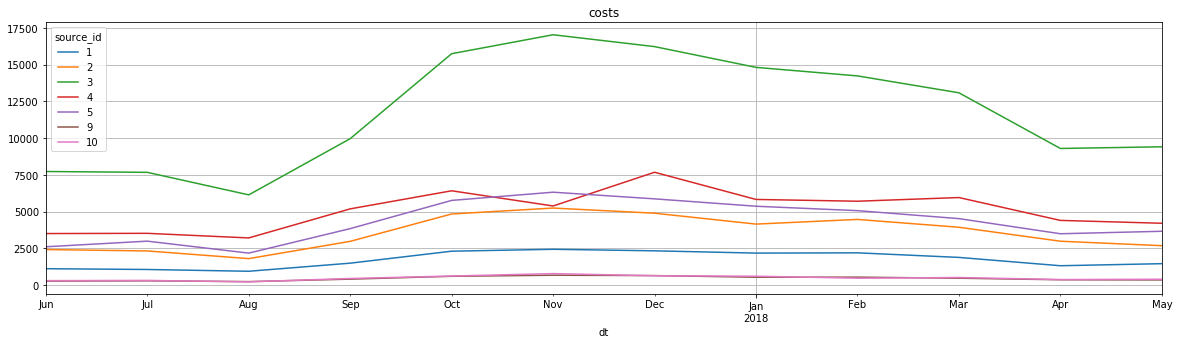

In [81]:
costs_graf =  pd.pivot_table(costs, index='dt', columns=['source_id'], values='costs', aggfunc= {'costs': 'sum'}  )
costs_graf.plot( grid=True, figsize=(20, 5),title='costs')
plt.show()

### Шаг 5. Общий вывод

Источник хороший, если его ROMI > 1. Два источника: 3 и 10 меньше 1. Целесообразно распределить бюджет на 1 источник.   Хотя   привлечение одного покупателя в среднем обошлось компании в 8.9 . Валовая прибыль с каждого из них: 13. То есть вложения в привлечение покупателей окупились. Стоит сделать аудит маркетинговой компании(самые большие деньги по неэффективному источнику)